# Chatbot (Generasi Puisi) menggunakan Transformer Architecture

## Anggota Kelompok
1. Zakiyah Hasanah (2305274)
2. Putra Hadiyanto Nugroho (2308163)
3. Hafsah Hamidah (2311474)
4. Natasha Adinda Cantika (2312120)

***

## Pendahuluan

Proyek ini bertujuan untuk membuat model Text Generation yang mampu menghasilkan puisi baru berdasarkan input berupa judul puisi menggunakan arsitektur **Transformer**. Berbeda dengan RNN/LSTM yang memproses data secara sekuensial, Transformer menggunakan mekanisme **Self-Attention** yang memungkinkan model untuk memperhatikan semua posisi dalam sequence secara paralel.

### Keunggulan Transformer:
* **Paralelisasi**, dapat memproses seluruh sequence secara bersamaan (tidak seperti RNN yang sequential)  
* ***Long-range dependencies***, lebih baik dalam menangani dependensi jangka panjang
* ***Self-attention***, dapat fokus pada bagian penting dari input secara otomatis
* ***Positional encoding***, menangani informasi posisi tanpa rekurensi

### Sumber Dataset
Dataset Puisi Indonesia dari Ilham Firdausi Putra di Kaggle:
https://www.kaggle.com/datasets/ilhamfp31/puisi-indonesia/

---

## 1. Persiapan dan Import Library

Langkah pertama adalah mengimpor semua *library* yang diperlukan untuk pemrosesan data, *preprocessing*, dan pembangunan model *deep learning* menggunakan TensorFlow dan Keras.

In [ ]:
# Import library utama untuk data processing
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import TensorFlow dan Keras untuk deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Definisi Hyperparameter dan Token Khusus

Pada tahap ini, kami mendefinisikan parameter-parameter kunci (*hyperparameters*) untuk arsitektur Transformer. Selain itu, kami juga menetapkan token-token khusus (`<start>`, `<end>`, `<br>`, `<unk>`) untuk membantu model memahami struktur teks puisi, seperti awal, akhir, dan pergantian baris.

In [ ]:
# Token khusus untuk menangani awal, akhir, dan struktur puisi
START_TOKEN = '<start>'    # Token penanda awal puisi
END_TOKEN = '<end>'        # Token penanda akhir puisi
UNK_TOKEN = '<unk>'        # Token untuk kata yang tidak dikenal
NEWLINE_TOKEN = '<br>'     # Token untuk baris baru dalam puisi

# Hyperparameter untuk Transformer
EMBEDDING_DIM = 128        # Dimensi embedding kata
NUM_HEADS = 4              # Jumlah attention heads
FF_DIM = 64                # Dimensi feedforward network
NUM_LAYERS = 3             # Jumlah layer transformer
DROPOUT_RATE = 0.1         # Dropout rate untuk regularisasi

# Parameter training
BATCH_SIZE = 32           # Ukuran batch (lebih kecil untuk Transformer)
EPOCHS = 50               # Jumlah epoch training
LEARNING_RATE = 0.001     # Learning rate

print("Hyperparameter berhasil didefinisikan!")
print(f"Model akan menggunakan {NUM_LAYERS} layer Transformer dengan {NUM_HEADS} attention heads")

Hyperparameter berhasil didefinisikan!
Model akan menggunakan 3 layer Transformer dengan 4 attention heads


## 3. Pengambilan dan Pembersihan Data

Mengunduh/membaca dataset puisi dan melakukan preprocessing teks.

In [ ]:
# Read dataset puisi Indonesia
df = pd.read_csv("puisi.csv")

print("Dataset berhasil diunduh!")
print(f"Jumlah data awal: {len(df)}")
df.info()

Dataset berhasil diunduh!
Jumlah data awal: 7223
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7223 entries, 0 to 7222
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   puisi              7221 non-null   object
 1   title              6903 non-null   object
 2   author             6697 non-null   object
 3   puisi_with_header  7223 non-null   object
dtypes: object(4)
memory usage: 225.8+ KB


Langkah krusial berikutnya adalah *data preprocessing* dan pembersihan teks (*text cleaning*).

Proses pembersihan ini mencakup beberapa langkah krusial, seperti menghapus data yang hilang (*missing values*) pada kolom `puisi` dan `title`, mengubah semua teks menjadi *lowercase*, mengganti karakter *newline* (`\n`) dengan token khusus (`<br>`) agar model dapat mempelajari struktur poem, serta menghapus karakter-karakter yang tidak diperlukan (tanda baca, simbol) untuk mengurangi *noise* pada data.

In [ ]:
# Membersihkan dan memilih kolom yang diperlukan
df = df[['puisi', 'title']].dropna().reset_index(drop=True)
print(f"Data setelah dibersihkan: {len(df)} baris")

# Fungsi untuk membersihkan teks
def clean_text(text, is_poem=False):
    """
    Membersihkan teks dan mengganti newline dengan token khusus untuk puisi
    """
    text = str(text).lower()

    if is_poem:
        # Ganti multiple newlines dengan single newline
        text = re.sub(r'\n+', '\n', text)
        # Ganti newline dengan token khusus, tapi batasi jumlahnya
        text = re.sub(r'\n', ' ' + NEWLINE_TOKEN + ' ', text)
        # Hapus multiple <br> berurutan
        text = re.sub(r'(<br>\s*){3,}', NEWLINE_TOKEN + ' ' + NEWLINE_TOKEN + ' ', text)

    # Hapus karakter selain huruf, angka, spasi, dan token khusus
    text = re.sub(r'[^a-z0-9\s<>\[\]]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Contoh sebelum pembersihan
print("Contoh puisi sebelum dibersihkan:")
print(df['puisi'][1][:200] + "...")

# Membersihkan data
df['puisi'] = df['puisi'].apply(lambda x: clean_text(x, is_poem=True))
df['title'] = df['title'].apply(lambda x: clean_text(x, is_poem=False))

# Contoh setelah pembersihan
print("\nContoh puisi setelah dibersihkan:")
print(df['puisi'][1][:200] + "...")

df.head()

Data setelah dibersihkan: 6901 baris
Contoh puisi sebelum dibersihkan:
Gemericik senandung luluh merayu hati, 
 Terjamah larutan mensiasati. 
  
 Terus menyabani hingga rengkarnasi. 
 Putih sejuk teramat berarti. 
 Senantiasa menanti keputusan Tuhan kapan ia akan pergi. ...

Contoh puisi setelah dibersihkan:
gemericik senandung luluh merayu hati <br> terjamah larutan mensiasati <br> <br> terus menyabani hingga rengkarnasi <br> putih sejuk teramat berarti <br> senantiasa menanti keputusan tuhan kapan ia ak...


,puisi,title
0,tiada lagi resah di hatiku <br> tiada lagi ker...,untuk kekasihku
1,gemericik senandung luluh merayu hati <br> ter...,hujan
2,kau adalah separuh hidup ku <br> hanya kepadam...,kau
3,mungkin kau membiarkan aku <br> membiarkan per...,teperangkap
4,ibu <br> kau adalah mutiara hatiku <br> mutiar...,ibu


## 4. Persiapan Data untuk Transformer

Untuk Transformer, kita akan menggunakan pendekatan **GPT-style** (autoregressive) dimana model belajar memprediksi kata berikutnya dari sequence yang diberikan. Data akan digabungkan menjadi satu sequence: `[TITLE] judul [POEM] isi_puisi [END]`

In [ ]:
# Token tambahan untuk memisahkan judul dan puisi
TITLE_TOKEN = '[TITLE]'
POEM_TOKEN = '[POEM]'

# Menggabungkan judul dan puisi menjadi satu sequence
combined_texts = []
for _, row in df.iterrows():
    # Format: [TITLE] judul [POEM] puisi [END]
    combined_text = f"{TITLE_TOKEN} {row['title']} {POEM_TOKEN} {row['puisi']} {END_TOKEN}"
    combined_texts.append(combined_text)

print(f"Total {len(combined_texts)} sequence gabungan dibuat")
print("Contoh sequence gabungan:")
print(combined_texts[0][:300] + "...")

# Split data menjadi train dan test
train_texts, test_texts = train_test_split(combined_texts, test_size=0.2, random_state=42)
print(f"\nData training: {len(train_texts)}")
print(f"Data testing: {len(test_texts)}")

Total 6901 sequence gabungan dibuat
Contoh sequence gabungan:
[TITLE] untuk kekasihku [POEM] tiada lagi resah di hatiku <br> tiada lagi keraguan kini <br> aku yakin hanyalah dirimu <br> yang ku sayangi <br> setiap langkah akupunberjanji <br> akan selalau setia bersama <br> kaulah nafasku <br> kaulah khayalanku <br> kaulah damai dalam detak jantungkuoh <br> kas...

Data training: 5520
Data testing: 1381


In [ ]:
# Tokenisasi menggunakan Keras Tokenizer
# Pastikan semua token khusus tidak dihapus
tokenizer = Tokenizer(oov_token=UNK_TOKEN, filters='')
tokenizer.fit_on_texts(train_texts)

# Konversi teks menjadi sequence angka
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Informasi vocabulary
vocab_size = len(tokenizer.word_index) + 1
print(f"Ukuran vocabulary: {vocab_size}")
print(f"Token khusus yang terdaftar:")
for token in [TITLE_TOKEN, POEM_TOKEN, START_TOKEN, END_TOKEN, NEWLINE_TOKEN, UNK_TOKEN]:
    if token in tokenizer.word_index:
        print(f"  {token}: {tokenizer.word_index[token]}")

# Tentukan panjang maksimum sequence
max_length = max(len(seq) for seq in train_sequences)
# Batasi panjang maksimum untuk efisiensi
MAX_LEN = min(max_length, 150)  # Transformer lebih sensitive terhadap panjang sequence

print(f"\nPanjang maksimum sequence asli: {max_length}")
print(f"Panjang maksimum yang digunakan: {MAX_LEN}")

Ukuran vocabulary: 38920
Token khusus yang terdaftar:
  <end>: 13
  <br>: 2
  <unk>: 1

Panjang maksimum sequence asli: 1405
Panjang maksimum yang digunakan: 150



Selanjutnya, data ini diubah menjadi *dataset* *input* dan *target* untuk *training*. Model akan dilatih untuk memprediksi token `y_i` (target) berdasarkan *sequence* `X_i` (input), di mana **Input (X)** adalah `sequence[:i]` dan **Target (y)** adalah `sequence[i]`. Setelah itu, data di-tokenisasi (diubah menjadi angka) dan di-padding agar memiliki panjang yang seragam (`MAX_LEN-1`) untuk *input* model.


In [ ]:
# Membuat data training untuk autoregressive language modeling
# Input: sequence[:-1], Target: sequence[1:]

def create_training_data(sequences, max_len):
    """
    Membuat data training untuk autoregressive language modeling.
    Input: sequence[:-1], Target: sequence[1:]
    """
    input_sequences = []
    target_sequences = []

    for seq in sequences:
        if len(seq) > 1:  # Ensure sequence has at least two tokens
            # Create input-target pairs for predicting the next token
            for i in range(1, len(seq)):
                input_sequences.append(seq[:i])
                target_sequences.append(seq[i])

    return input_sequences, target_sequences

# Buat data training
print("Membuat data training...")
X_train, y_train = create_training_data(train_sequences, MAX_LEN)
X_test, y_test = create_training_data(test_sequences, MAX_LEN)

print(f"Jumlah contoh training: {len(X_train)}")
print(f"Jumlah contoh testing: {len(X_test)}")

# Padding untuk menyamakan panjang input
# Pad input sequences to max_len - 1
X_train_pad = pad_sequences(X_train, maxlen=MAX_LEN-1, padding='post')
X_test_pad = pad_sequences(X_test, maxlen=MAX_LEN-1, padding='post')

y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"Shape data training: X={X_train_pad.shape}, y={y_train.shape}")
print(f"Shape data testing: X={X_test_pad.shape}, y={y_test.shape}")

print("\nPersiapan data selesai!")

Membuat data training...
Jumlah contoh training: 653232
Jumlah contoh testing: 164064
Shape data training: X=(653232, 149), y=(653232,)
Shape data testing: X=(164064, 149), y=(164064,)

Persiapan data selesai!


## 5. Implementasi Transformer Architecture

Arsitektur Transformer *decoder-only* (generatif) dibiangun dari awal. Komponen utamanya adalah **Positional Embedding**, yang menggabungkan *token embedding* (makna kata) dengan *positional embedding* (informasi posisi kata) karena Transformer tidak memiliki sifat rekuren. Komponen penting kedua adalah **Causal Attention Mask**, yang sangat penting untuk model *autoregressive*. Masker ini memastikan bahwa saat memprediksi token di posisi `i`, model hanya dapat memperhatikan (memberi *attention*) pada token-token di posisi `< i`. Komponen ketiga adalah **Transformer Block**, unit inti yang di-*stack* (ditumpuk). Setiap blok ini terdiri dari *Masked Multi-Head Self-Attention*, *Feed-Forward Network*, serta *Residual Connections* dan *Layer Normalization* untuk menstabilkan *training*.

Model kemudian diakhiri dengan *Dense layer* dan aktivasi *Softmax* untuk memprediksi probabilitas token berikutnya dari seluruh *vocabulary*.

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Layer untuk menambahkan positional encoding ke token embeddings
    Karena Transformer tidak memiliki rekurensi, kita perlu memberi informasi posisi
    """
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super().__init__()
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # Token embedding layer
        self.token_embeddings = Embedding(vocab_size, embed_dim)
        # Positional embedding layer
        self.position_embeddings = Embedding(sequence_length, embed_dim)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)

        # Gabungkan token embedding dengan positional embedding
        token_emb = self.token_embeddings(inputs)
        pos_emb = self.position_embeddings(positions)

        return token_emb + pos_emb

class TransformerBlock(tf.keras.layers.Layer):
    """
    Satu blok Transformer yang terdiri dari:
    1. Multi-Head Self-Attention dengan causal masking
    2. Feed-Forward Network
    3. Residual connections dan Layer Normalization
    """
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim

        # Multi-head attention layer (tanpa use_causal_mask parameter)
        self.attention = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim//num_heads  # Key dimension per head
        )

        # Feed-forward network
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])

        # Layer normalization
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        # Dropout for regularization
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def get_causal_attention_mask(self, inputs):
        """
        Membuat causal attention mask untuk autoregressive modeling
        """
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        # Buat lower triangular matrix (causal mask)
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

        # Konversi ke boolean mask dan reshape untuk MultiHeadAttention
        # Shape: (batch_size, 1, seq_len, seq_len)
        mask = tf.cast(mask, tf.bool)
        mask = tf.expand_dims(tf.expand_dims(mask, 0), 0)
        mask = tf.tile(mask, [batch_size, 1, 1, 1])

        return mask

    def call(self, inputs, training=None):
        # Buat causal mask
        causal_mask = self.get_causal_attention_mask(inputs)

        # Multi-head self-attention dengan causal mask manual
        attention_output = self.attention(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            training=training
        )
        attention_output = self.dropout1(attention_output, training=training)

        # Residual connection + layer norm
        out1 = self.layernorm1(inputs + attention_output)

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        # Residual connection + layer norm
        return self.layernorm2(out1 + ffn_output)

print("Komponen Transformer berhasil didefinisikan!")

Komponen Transformer berhasil didefinisikan!


In [ ]:
def create_causal_mask_layer():
    """
    Membuat layer untuk causal mask dalam Keras
    """
    class CausalMask(tf.keras.layers.Layer):
        def call(self, inputs):
            length = tf.shape(inputs)[-1]
            # Buat causal mask menggunakan tf.linalg.band_part
            mask = tf.linalg.band_part(tf.ones((length, length)), -1, 0)
            # Konversi ke format yang dibutuhkan oleh MultiHeadAttention
            # Shape: (batch_size, num_heads, seq_len, seq_len)
            mask = tf.expand_dims(tf.expand_dims(mask, 0), 0)
            return mask

    return CausalMask()

def create_transformer_model(vocab_size, max_length, embed_dim, num_heads, ff_dim, num_layers, dropout_rate):
    """
    Membuat model Transformer lengkap untuk text generation

    Args:
        vocab_size (int): Ukuran vocabulary
        max_length (int): Panjang maksimum sequence
        embed_dim (int): Dimensi embedding
        num_heads (int): Jumlah attention heads
        ff_dim (int): Dimensi feed-forward network
        num_layers (int): Jumlah transformer layers
        dropout_rate (float): Dropout rate

    Returns:
        tf.keras.Model: Model Transformer
    """
    # Input layer
    inputs = Input(shape=(max_length,), name="input_tokens")

    # Positional embedding
    embedding_layer = PositionalEmbedding(max_length, vocab_size, embed_dim)
    x = embedding_layer(inputs)

    # Stack transformer blocks
    for i in range(num_layers):
        transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
        x = transformer_block(x)

    # Ambil hanya output dari posisi terakhir untuk next token prediction
    # Ini menyelesaikan masalah shape mismatch
    last_output = tf.keras.layers.Lambda(lambda x: x[:, -1, :], name="last_position")(x)

    # Output layer untuk prediksi token berikutnya
    outputs = Dense(vocab_size, activation="softmax", name="output_probs")(last_output)

    model = Model(inputs=inputs, outputs=outputs, name="poetry_transformer")
    return model

# Buat model Transformer
print("Membuat model Transformer...")
transformer_model = create_transformer_model(
    vocab_size=vocab_size,
    max_length=MAX_LEN-1,  # -1 karena kita prediksi token berikutnya
    embed_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    dropout_rate=DROPOUT_RATE
)

# Compile model
transformer_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model Transformer berhasil dibuat!")
transformer_model.summary()

Membuat model Transformer...
Model Transformer berhasil dibuat!


Model: "poetry_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_tokens (InputLayer)       │ (None, 149)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding            │ (None, 149, 128)       │     5,000,832 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 149, 128)       │        83,136 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 149, 128)       │        83,136 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 149, 128)       │        83,136 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_position (Lambda)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probs (Dense)            │ (None, 38920)          │     5,020,680 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,270,920 (39.18 MB)

 Trainable params: 10,270,920 (39.18 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Pelatihan Model Transformer

Melatih model dengan data training yang sudah disiapkan.

Model di-*compile* menggunakan *optimizer* Adam dan *loss function* `sparse_categorical_crossentropy` (karena target kami adalah *integer* indeks token, bukan *one-hot encoding*).

Proses *training* dilakukan dengan *callback* `EarlyStopping` untuk mencegah *overfitting* (berhenti jika *validation loss* tidak membaik) dan `ReduceLROnPlateau` untuk menyesuaikan *learning rate* secara dinamis.

In [ ]:
# Setup callback untuk monitoring training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping jika tidak ada improvement
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate jika stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

print("Memulai pelatihan model Transformer...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print("-" * 50)

# Train model
history = transformer_model.fit(
    X_train_pad,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nPelatihan selesai!")

Memulai pelatihan model Transformer...
Batch size: 32
Epochs: 50
Learning rate: 0.001
--------------------------------------------------
Epoch 1/50
20414/20414 ━━━━━━━━━━━━━━━━━━━━ 342s 16ms/step - accuracy: 0.1646 - loss: 6.9268 - val_accuracy: 0.1650 - val_loss: 6.8689 - learning_rate: 0.0010
Epoch 2/50
20414/20414 ━━━━━━━━━━━━━━━━━━━━ 318s 16ms/step - accuracy: 0.1660 - loss: 6.7550 - val_accuracy: 0.1650 - val_loss: 6.8827 - learning_rate: 0.0010
Epoch 3/50
20414/20414 ━━━━━━━━━━━━━━━━━━━━ 308s 15ms/step - accuracy: 0.1661 - loss: 6.7785 - val_accuracy: 0.1650 - val_loss: 6.8983 - learning_rate: 0.0010
Epoch 4/50
20414/20414 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1659 - loss: 6.7905
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
20414/20414 ━━━━━━━━━━━━━━━━━━━━ 307s 15ms/step - accuracy: 0.1659 - loss: 6.7905 - val_accuracy: 0.1650 - val_loss: 6.9307 - learning_rate: 0.0010
Epoch 5/50
20414/20414 ━━━━━━━━━━━━━━━━━━━━ 305s 15ms/step - accuracy: 

## 7. Visualisasi Hasil Training

Setelah *training* selesai, kami memvisualisasikan metrik *loss* dan *accuracy* dari *training* dan *validation* untuk mengevaluasi performa model.

*(Catatan: Berdasarkan hasil plot, terlihat bahwa loss training dan validasi masih tinggi dan tidak banyak menurun, sementara akurasi sangat rendah (sekamir 16%). Ini mengindikasikan model mengalami *underfitting* atau *stuck* di *local minimum*. Model ini memerlukan *tuning* hyperparameter lebih lanjut, arsitektur yang lebih besar, atau *training* yang lebih lama untuk dapat menghasilkan teks yang koheren.)*

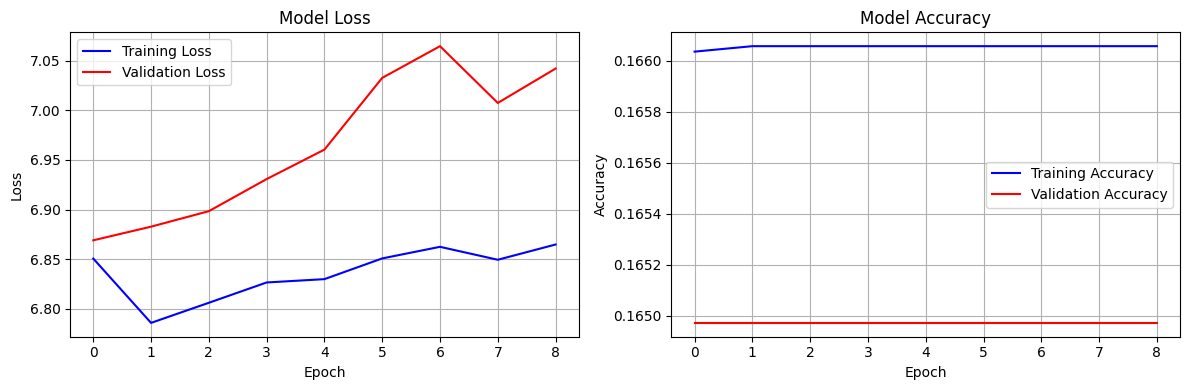

Hasil akhir pelatihan:
Training Loss: 6.8647
Validation Loss: 7.0422
Training Accuracy: 0.1661
Validation Accuracy: 0.1650


In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print hasil akhir
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Hasil akhir pelatihan:")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")

Untuk memahami bagaimana model "berpikir", kami memvisualisasikan distribusi probabilitas *softmax* pada *output layer*. Ini menunjukkan token-token mana yang dianggap paling mungkin oleh model sebagai kelanjutan dari *input* "cinta adalah".

=== VISUALISASI 1: DISTRIBUSI PROBABILITAS TOKEN ===
Debug - Predictions shape: (1, 38920)
Debug - Sequence length: 2
Debug - Probs shape: (38920,)


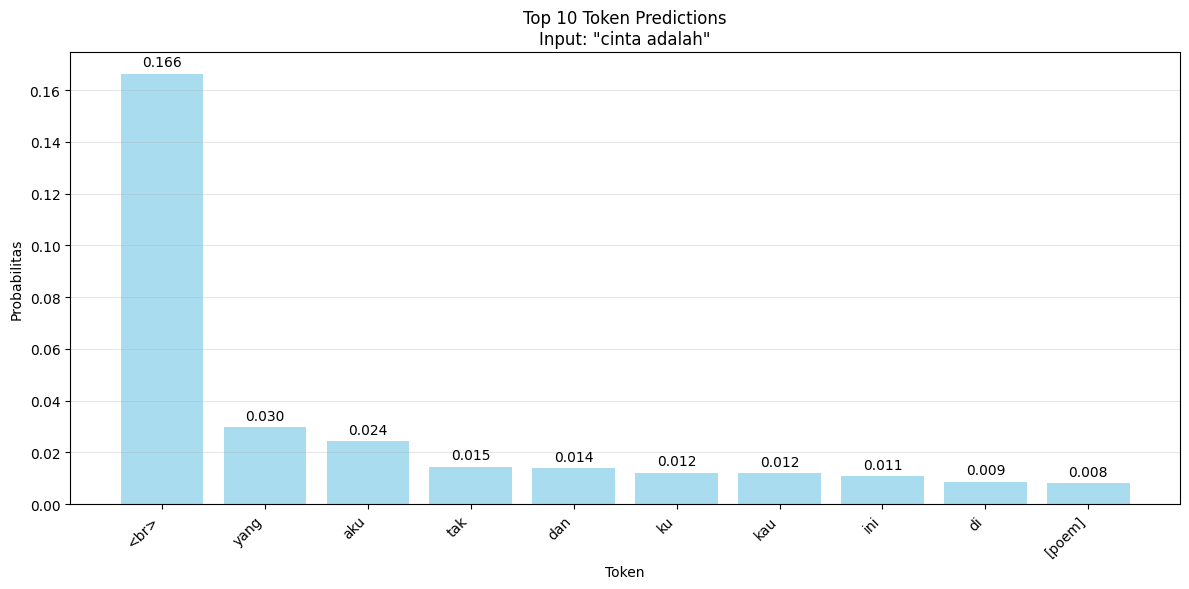

In [ ]:
# Visualisasi Distribusi Probabilitas Token pada Sample Input
import matplotlib.pyplot as plt
import numpy as np

def visualize_token_probabilities(model, tokenizer, input_text, max_tokens_to_show=10):
    """Visualisasi probabilitas token tertinggi untuk input tertentu"""

    # Siapkan input
    sequence = tokenizer.texts_to_sequences([input_text])[0]
    padded = pad_sequences([sequence], maxlen=MAX_LEN-1, padding='post')

    # Prediksi model
    predictions = model.predict(padded, verbose=0)

    # Debug: Print shapes to understand the structure
    print(f"Debug - Predictions shape: {predictions.shape}")
    print(f"Debug - Sequence length: {len(sequence)}")

    # Handle different prediction shapes
    if len(predictions.shape) == 3:
        # Shape: (batch_size, sequence_length, vocab_size)
        predictions = predictions[0]  # Remove batch dimension
    elif len(predictions.shape) == 2:
        # Shape: (sequence_length, vocab_size) - already correct
        pass
    else:
        print(f"Unexpected predictions shape: {predictions.shape}")
        return

    # Ambil posisi terakhir yang memiliki input (bukan padding)
    last_position = len(sequence) - 1
    if last_position >= len(predictions):
        last_position = len(predictions) - 1

    # Ambil probabilitas untuk posisi terakhir
    probs = predictions[last_position]

    # Ensure probs is 1D array
    if len(probs.shape) > 1:
        probs = probs.flatten()

    # Debug: Check probs shape
    print(f"Debug - Probs shape: {probs.shape}")

    # Cari token dengan probabilitas tertinggi
    if len(probs) > max_tokens_to_show:
        top_indices = np.argsort(probs)[-max_tokens_to_show:][::-1]
    else:
        top_indices = np.argsort(probs)[::-1]

    # Konversi index ke kata
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    top_words = [reverse_word_index.get(idx, f'UNK_{idx}') for idx in top_indices]
    top_probs = [probs[idx] for idx in top_indices]

    # Buat visualisasi
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(top_words)), top_probs, color='skyblue', alpha=0.7)
    plt.xlabel('Token')
    plt.ylabel('Probabilitas')
    plt.title(f'Top {len(top_indices)} Token Predictions\nInput: "{input_text}"')
    plt.xticks(range(len(top_words)), top_words, rotation=45, ha='right')

    # Tambahkan nilai probabilitas di atas setiap bar
    for i, (word, prob) in enumerate(zip(top_words, top_probs)):
        plt.text(i, prob + max(top_probs)*0.01, f'{prob:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Test dengan contoh input
sample_input = "cinta adalah"
print("=== VISUALISASI 1: DISTRIBUSI PROBABILITAS TOKEN ===")
visualize_token_probabilities(transformer_model, tokenizer, sample_input)

## 8. Implementasi Text Generation

Membuat fungsi untuk generate puisi dari judul menggunakan model Transformer yang sudah dilatih.

Fungsi *text generation* dibuat untuk menghasilkan puisi secara *autoregressive*. Fungsi ini mengambil judul sebagai *seed text*, kemudian memprediksi token demi token.

Pada setiap langkah, token berikutnya dipilih menggunakan *temperature sampling* (dengan fungsi `sample_token`) untuk mengontrol variasi output. Token-token struktural seperti `[TITLE]` dan `[POEM]` juga difilter dari hasil prediksi agar tidak muncul di tengah-tengah puisi.

In [ ]:
def sample_token(predictions, temperature=0.8):
    """
    Sampling token berikutnya dengan temperature untuk mengontrol randomness

    Args:
        predictions (array): Array probabilitas untuk setiap token
        temperature (float): Temperature untuk controlling randomness
                           - Rendah (0.5): lebih konservatif/predictable
                           - Tinggi (1.0): lebih kreatif/random

    Returns:
        int: Index token yang dipilih
    """
    # Ensure predictions is a 1D array of probabilities
    if predictions.ndim > 1:
        # If it's not 1D, we might have an issue, but try to flatten or take the first element
        # (This is a safeguard; the main fix is in generate_poetry)
        predictions = predictions.flatten()
        # Or, if we expect a batch of size 1, take the first element:
        # predictions = predictions[0]
        print("Warning: sample_token received non-1D predictions. Attempting to flatten.")


    predictions = np.asarray(predictions).astype('float64')
    # Add a small epsilon to avoid log(0)
    predictions = np.log(predictions + 1e-10) / temperature
    exp_preds = np.exp(predictions)
    # Handle potential NaNs or infs after exp
    exp_preds[~np.isfinite(exp_preds)] = 0
    predictions = exp_preds / np.sum(exp_preds)

    # Handle cases where sum is zero (e.g., all predictions were effectively zero)
    if np.sum(predictions) == 0:
        # Fallback to uniform distribution or a default token
        print("Warning: Probabilities sum to zero. Returning UNK_TOKEN.")
        return tokenizer.word_index.get(UNK_TOKEN, 0) # Use get with default 0

    # Only sample if predictions sum to > 0 (handled in the else block above)
    if np.sum(predictions) > 0:
         probas = np.random.multinomial(1, predictions, 1)
         return np.argmax(probas)
    else:
         # If sum is still zero, return UNK_TOKEN or handle as appropriate
         print("Warning: Probabilities still sum to zero after re-normalization. Returning UNK_TOKEN.")
         return tokenizer.word_index.get(UNK_TOKEN, 0)


def generate_poetry(model, tokenizer, seed_title, max_length=100, temperature=0.8):
    """
    Generate puisi dengan filtering token struktural
    """
    clean_title = clean_text(seed_title)
    prompt = f"{TITLE_TOKEN} {clean_title} {POEM_TOKEN}"
    sequence = tokenizer.texts_to_sequences([prompt])[0]

    # Token IDs yang harus difilter dari prediksi
    structural_tokens = [
        tokenizer.word_index.get(TITLE_TOKEN, 0),
        tokenizer.word_index.get(POEM_TOKEN, 0),
        tokenizer.word_index.get(END_TOKEN, 0), # Also filter END_TOKEN during generation loop
    ]

    for _ in range(max_length):
        if len(sequence) >= MAX_LEN - 1:
            break

        padded = pad_sequences([sequence], maxlen=MAX_LEN-1, padding='post')
        predictions = model.predict(padded, verbose=0)[0]

        # FILTER: Set probabilitas token struktural ke 0
        # Ensure token_id is valid before setting probability
        for token_id in structural_tokens:
             if token_id is not None and token_id > 0 and token_id < len(predictions):
                predictions[token_id] = 0.0


        # Renormalisasi probabilitas
        # Check if the sum is still positive after filtering
        sum_predictions = np.sum(predictions)
        if sum_predictions > 0:
             predictions = predictions / sum_predictions
        else:
             # Fallback if all valid tokens have zero probability
             print("Warning: All valid token probabilities are zero after filtering. Falling back to UNK_TOKEN.")
             next_token = tokenizer.word_index.get(UNK_TOKEN, 0)
             # If UNK_TOKEN is not found or is 0, sample a random token
             if next_token == 0:
                  next_token = np.random.choice(len(predictions))
             sequence.append(next_token)
             continue # Skip sampling and go to the next iteration

        next_token = sample_token(predictions, temperature)


        # Stop jika bertemu END_TOKEN (atau jika UNK_TOKEN is the END_TOKEN ID - unlikely)
        if next_token == tokenizer.word_index.get(END_TOKEN, 0):
            break

        sequence.append(next_token)

    # Post-processing: hapus semua token struktural dari output string
    generated_text = tokenizer.sequences_to_texts([sequence])[0]

    # Remove structural tokens as strings, including potential extra spaces, case-insensitive
    tokens_to_remove = [TITLE_TOKEN, POEM_TOKEN, END_TOKEN, UNK_TOKEN] # Also remove UNK_TOKEN from output

    for token in tokens_to_remove:
        # Remove the token with any surrounding whitespace, case-insensitive
        generated_text = re.sub(rf'\s*{re.escape(token)}\s*', ' ', generated_text, flags=re.IGNORECASE)

    poem_part = re.sub(r'\s+', ' ', generated_text).strip() # Clean up extra spaces

    # FORMATTING: Replace NEWLINE_TOKEN with actual newlines
    poem_part = poem_part.replace(NEWLINE_TOKEN, '\n')

    return poem_part.strip()

print("Fungsi text generation berhasil didefinisikan!")

Fungsi text generation berhasil didefinisikan!


In [ ]:
def filter_consecutive_newlines(poem_string):
    # 1. Menghapus newline di awal atau akhir string
    poem_string = poem_string.strip('\n')

    # 2. Mengganti 2+ karakter newline dengan hanya satu (\n)
    # Regex: \n\s*\n+ mencari 2 atau lebih \n dengan spasi opsional di antaranya
    filtered_poem = re.sub(r'\n\s*\n+', '\n', poem_string)

    return filtered_poem

## 9. Testing dan Evaluasi Model

Menguji model dengan beberapa judul dan mengevaluasi kualitas puisi yang dihasilkan.
Kami menguji model dengan memberikan beberapa judul sebagai *input* dan mengamati puisi yang dihasilkan.

Selain evaluasi kualitatif (membaca koherensi puisi), kami juga melakukan evaluasi kuantitatif menggunakan **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**. Skor ROUGE (ROUGE-1, ROUGE-2, ROUGE-L) dihitung dengan membandingkan puisi yang dihasilkan model dengan sekumpulan puisi referensi acak dari *dataset* untuk mengukur kesamaan *n-gram* dan *subsequence*.

*(Catatan: Skor ROUGE yang dihasilkan sangat rendah, yang sejalan dengan metrik akurasi *training* yang rendah. Ini menegaskan bahwa model saat ini belum mampu menangkap pola bahasa atau struktur puisi dengan baik.)*

In [ ]:
# Test dengan beberapa judul
test_titles = [
    "cinta",
    "hujan",
    "malam",
    "rindu",
    "kebahagiaan"
]

print("=" * 60)
print("HASIL TESTING MODEL TRANSFORMER")
print("=" * 60)

generated_poems = []

for title in test_titles:
    print(f"\nJUDUL: {title.upper()}")
    print("-" * 40)

    # Generate puisi dengan temperature yang berbeda untuk variasi
    poem = generate_poetry(
        model=transformer_model,
        tokenizer=tokenizer,
        seed_title=title,
        max_length=80,
        temperature=0.8
    )

    # Format puisi (ganti \\n dengan newline sebenarnya)
    formatted_poem = filter_consecutive_newlines(poem)
    print("PUISI YANG DIHASILKAN:")
    print(formatted_poem)
    print("\n" + "="*60)

    generated_poems.append({
        'title': title,
        'poem': formatted_poem
    })

HASIL TESTING MODEL TRANSFORMER

JUDUL: CINTA
----------------------------------------
PUISI YANG DIHASILKAN:
cinta aku kamu 
 nilai tak tak sayangmu ketika sedang yang 
 mati bisa susun pelukan begitu 
 dengan ada 
 rantau aku 
 sore 
 aku 
 kau kau aku ya 
 angin 
 tatapan itu dan 
 hanya rahasia 
 tak semua sendiri 
 kau buku 
 ku 
 senyumku dan hilang kamu yang manis tetap 8854 pernah 
 yang dengan 
 rindu masih jauh 
 kau sang


JUDUL: HUJAN
----------------------------------------
PUISI YANG DIHASILKAN:
hujan sang 
 di malam yang 
 ku dengan kau memanggil dunia 
 dengan kau 
 pada 
 sudah 
 waktu dia 
 ucapkan 
 langkah lemah sampai yang 
 aku yang ku pada sakit 
 yang harus yang ku akan 
 timur mungkinkah 
 dan bicara torehkan yang bersamamu agar aku 
 aku ini yang 
 aku 
 cinta 
 bualan atas sudah mata 
 justru pada


JUDUL: MALAM
----------------------------------------
PUISI YANG DIHASILKAN:
malam hingga bekerja dan 
 untuk 
 bercerita 
 kan 
 tanya mengucap 
 aku pergi 
 pel

In [ ]:
# Percobaan generate puisi dengan title yang agak panjang
user_title = "hujan pada hari yang gelap"

# Generate poetry using the user-provided title
generated_poem = generate_poetry(
    model=transformer_model,
    tokenizer=tokenizer,
    seed_title=user_title,
    max_length=150,  # You can adjust the maximum length of the generated poem
    temperature=0.8   # Adjust temperature for creativity (0.5-1.0)
)

# Format and print the generated poem
print("\n--- GENERATED POEM ---")
# Replace <br> with newline and remove potential double newlines
formatted_poem = filter_consecutive_newlines(generated_poem.replace('\\n', '\n'))
print(formatted_poem)

print("----------------------")


--- GENERATED POEM ---
hujan pada hari yang gelap tak 
 aku 
 atas yang aku buta tak 
 aku yang tak 
 aku 
 tak 
 kisah harapan 
 hanyalah 
 selalu 
 sadar lupa ilalang 
 aku his semesta hati juga 
 yang tentang pun 
 ku 
 yang tertawa yang 
 tidak aku 
 itu tak bila 
 kau 
 yang 
 ku 
 yang segala can waktu 
 selalu aku aku hitam yang hilang saat mulai alam hembusan 
 kau 
 tidak 
 tetap yang 
 yang bisa hanya 
 yang 
 senyummu yang 
 ruang 
 tak 
 segala ciptaan kapan rasa tiada yang mencari ku 
 yang engkaulah 
 kuat kembali memelukku tak 
 selalu 
 terasa dihatiku
----------------------


In [ ]:
# Evaluasi dengan ROUGE Score (optional - perlu install rouge-score)
# pip install rouge-score

try:
    from rouge_score import rouge_scorer

    # Ambil beberapa puisi asli dari dataset sebagai referensi
    reference_poems = df['puisi'].sample(10).tolist()

    # Bersihkan referensi (hapus token khusus)
    cleaned_references = []
    for poem in reference_poems:
        cleaned = poem.replace(NEWLINE_TOKEN, '\n').strip()
        cleaned_references.append(cleaned)

    # Hitung ROUGE score untuk puisi yang dihasilkan
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge_scores = []
    for gen_poem in generated_poems:
        poem_text = gen_poem['poem']

        # Hitung rata-rata ROUGE terhadap semua referensi
        scores = []
        for ref in cleaned_references:
            score = scorer.score(ref, poem_text)
            scores.append({
                'rouge1': score['rouge1'].fmeasure,
                'rouge2': score['rouge2'].fmeasure,
                'rougeL': score['rougeL'].fmeasure
            })

        # Rata-rata score
        avg_rouge1 = np.mean([s['rouge1'] for s in scores])
        avg_rouge2 = np.mean([s['rouge2'] for s in scores])
        avg_rougeL = np.mean([s['rougeL'] for s in scores])

        rouge_scores.append({
            'title': gen_poem['title'],
            'rouge1': avg_rouge1,
            'rouge2': avg_rouge2,
            'rougeL': avg_rougeL
        })

    # Tampilkan hasil ROUGE
    print("\nEVALUASI ROUGE SCORE:")
    print("-" * 50)
    print(f"{'Judul':<12} {'ROUGE-1':<10} {'ROUGE-2':<10} {'ROUGE-L':<10}")
    print("-" * 50)

    for score in rouge_scores:
        print(f"{score['title']:<12} {score['rouge1']:<10.4f} {score['rouge2']:<10.4f} {score['rougeL']:<10.4f}")

    # Rata-rata keseluruhan
    avg_rouge1 = np.mean([s['rouge1'] for s in rouge_scores])
    avg_rouge2 = np.mean([s['rouge2'] for s in rouge_scores])
    avg_rougeL = np.mean([s['rougeL'] for s in rouge_scores])

    print("-" * 50)
    print(f"{'RATA-RATA':<12} {avg_rouge1:<10.4f} {avg_rouge2:<10.4f} {avg_rougeL:<10.4f}")

except ImportError:
    print("Rouge-score tidak tersedia. Install dengan: pip install rouge-score")
    print("Evaluasi ROUGE dilewati.")

except Exception as e:
    print(f"Error dalam evaluasi ROUGE: {e}")
    print("Evaluasi ROUGE dilewati.")


EVALUASI ROUGE SCORE:
--------------------------------------------------
Judul        ROUGE-1    ROUGE-2    ROUGE-L   
--------------------------------------------------
cinta        0.1841     0.0032     0.1287    
hujan        0.1538     0.0075     0.1098    
malam        0.1613     0.0086     0.1086    
rindu        0.1786     0.0043     0.1157    
kebahagiaan  0.1728     0.0032     0.1176    
--------------------------------------------------
RATA-RATA    0.1701     0.0054     0.1161    


## 10. Export Model

Model yang telah dilatih (`.keras`), *tokenizer* (`.pkl`), dan file konfigurasi (`.pkl`) disimpan ke dalam *disk*. Ini memungkinkan model untuk di-*deploy* atau digunakan kembali di lingkungan lain tanpa perlu melakukan *training* ulang.

In [ ]:
# Simpan model dalam format .keras
MODEL_PATH = 'transformer_poetry_generator.keras'

try:
    transformer_model.save(MODEL_PATH)
    print(f"✅ Model berhasil disimpan di: {MODEL_PATH}")
except Exception as e:
    print(f"❌ Gagal menyimpan model: {e}")

# Simpan tokenizer juga (menggunakan pickle)
import pickle

TOKENIZER_PATH = 'tokenizer_poetry.pkl'

try:
    with open(TOKENIZER_PATH, 'wb') as f:
        pickle.dump(tokenizer, f)
    print(f"✅ Tokenizer berhasil disimpan di: {TOKENIZER_PATH}")
except Exception as e:
    print(f"❌ Gagal menyimpan tokenizer: {e}")

# Simpan konfigurasi model
config = {
    'vocab_size': vocab_size,
    'max_length': MAX_LEN,
    'embedding_dim': EMBEDDING_DIM,
    'num_heads': NUM_HEADS,
    'ff_dim': FF_DIM,
    'num_layers': NUM_LAYERS,
    'dropout_rate': DROPOUT_RATE,
    'special_tokens': {
        'START_TOKEN': START_TOKEN,
        'END_TOKEN': END_TOKEN,
        'UNK_TOKEN': UNK_TOKEN,
        'NEWLINE_TOKEN': NEWLINE_TOKEN,
        'TITLE_TOKEN': TITLE_TOKEN,
        'POEM_TOKEN': POEM_TOKEN
    }
}

CONFIG_PATH = 'model_config.pkl'

try:
    with open(CONFIG_PATH, 'wb') as f:
        pickle.dump(config, f)
    print(f"✅ Konfigurasi model berhasil disimpan di: {CONFIG_PATH}")
except Exception as e:
    print(f"❌ Gagal menyimpan konfigurasi: {e}")

print("\n" + "="*60)
print("MODEL EXPORT SELESAI!")
print("="*60)
print("File yang disimpan:")
print(f"1. Model: {MODEL_PATH}")
print(f"2. Tokenizer: {TOKENIZER_PATH}")
print(f"3. Config: {CONFIG_PATH}")
print("\nUntuk menggunakan model di masa mendatang:")
print("1. Load model dengan: tf.keras.models.load_model()")
print("2. Load tokenizer dengan: pickle.load()")
print("3. Load config dengan: pickle.load()")

✅ Model berhasil disimpan di: transformer_poetry_generator.keras
✅ Tokenizer berhasil disimpan di: tokenizer_poetry.pkl
✅ Konfigurasi model berhasil disimpan di: model_config.pkl

MODEL EXPORT SELESAI!
File yang disimpan:
1. Model: transformer_poetry_generator.keras
2. Tokenizer: tokenizer_poetry.pkl
3. Config: model_config.pkl

Untuk menggunakan model di masa mendatang:
1. Load model dengan: tf.keras.models.load_model()
2. Load tokenizer dengan: pickle.load()
3. Load config dengan: pickle.load()


## 11. Kesimpulan dan Perbandingan dengan RNN/LSTM

Model Transformer yang diimplementasikan dalam proyek ini (secara arsitektural) memiliki keunggulan konseptual dibandingkan RNN/LSTM untuk tugas generasi teks. Namun, hasil *training* spesifik ini belum optimal dan menunjukkan *underfitting* yang signifikan.

### 11.1 Perbandingan Arsitektur: Transformer vs. RNN/LSTM

Secara arsitektural, **Transformer** memiliki keunggulan dalam hal **Paralelisasi**, sehingga *training* bisa lebih cepat pada *hardware* yang memadai (GPU/TPU) karena pemrosesan non-sekuensial. Selain itu, **Konteks Global** yang dimilikinya melalui *self-attention* memungkinkan model menangkap hubungan antara kata "hujan" di awal puisi dan "basah" di akhir puisi secara langsung. Namun, kelemahannya adalah **Kompleksitas & Kebutuhan Memori** yang lebih tinggi, terutama untuk *sequence* yang sangat panjang.

Di sisi lain, arsitektur **RNN/LSTM** tradisional unggul dalam **Efisien Memori** dan **Sederhana** untuk dipahami. Namun, kekurangannya adalah proses **Training Sekuensial** yang lambat dan kesulitannya menangani **Masalah Dependensi Jangka Panjang**, di mana model cenderung "lupa" konteks dari kata-kata yang sangat jauh di awal *sequence* (*vanishing gradient problem*).

### 11.2 Catatan Pengembangan Lanjutan
Implementasi ini adalah *baseline* sederhana untuk tujuan pembelajaran. Untuk hasil yang jauh lebih baik, langkah selanjutnya dapat mencakup optimisasi *hyperparameter* (misalnya, *learning rate*, *embedding size*, jumlah *heads*, dan *dropout rate*), melakukan *training* dengan jumlah *epoch* yang jauh lebih banyak pada GPU yang lebih kuat, menggunakan arsitektur yang sudah di-*pre-trained* (seperti GPT-2 atau T5) untuk *fine-tuning* pada *dataset* puisi, serta melakukan pembersihan data yang lebih canggih untuk mengurangi *noise*.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=45d21e8d-8046-4087-9cb0-33fc5fd9dc0e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>